# Survival Analysis

In [ ]:
pip install miceforest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.2 MB/s eta 0:00:00


In [ ]:
# Import neccessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf

# Strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion..
from sklearn.impute import KNNImputer

## Read Dataset

In [ ]:
df = pd.read_csv('/content/train.csv')

In [ ]:
# head
df.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


## Overview of the Data

In [ ]:
# info.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

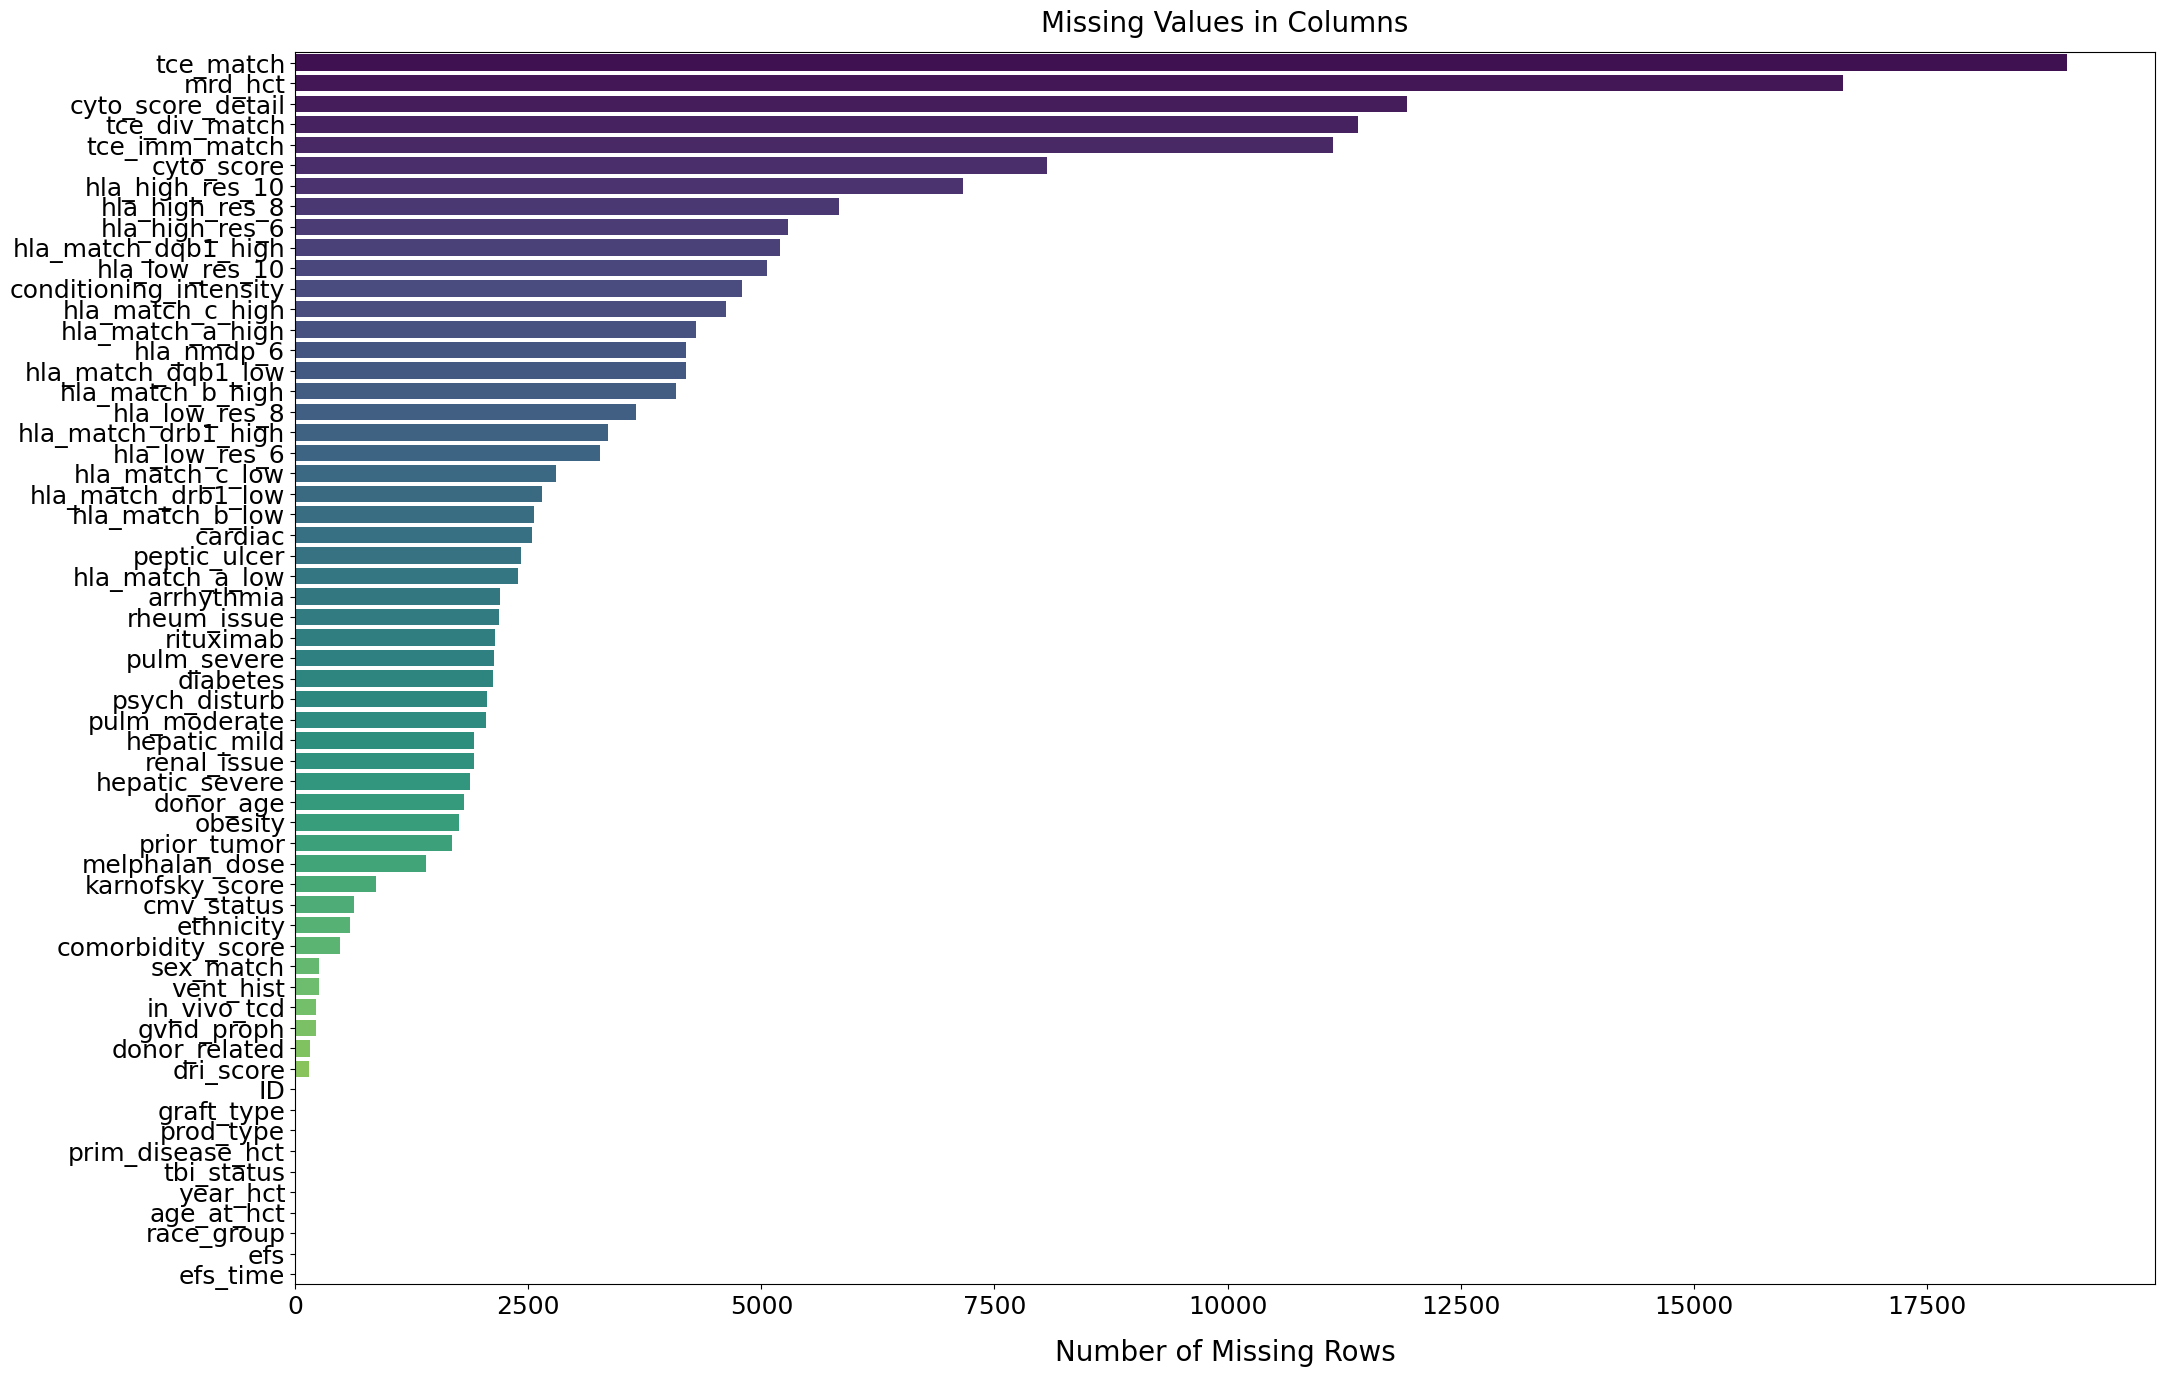

In [ ]:
# Finding missing values.
fig = plt.figure(figsize=(24, 16))

sns.barplot(x=df.isnull().sum().sort_values(ascending=False).values,
            y=df.isnull().sum().sort_values(ascending=False).index,
            hue=df.isnull().sum().sort_values(ascending=False).index,
            palette='viridis',
            )

plt.xlabel('Number of Missing Rows', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Missing Values in Columns', size=20, pad=15)

plt.show()

There are 59 columns and only 10 columns don't have missing values in them. Most importantly, there are no missing values in time-to-event, event indicator.

In [ ]:
# Find the percentage of missing values.
df.isnull().sum() / df.shape[0] * 100

,0
ID,0.000000
dri_score,0.534722
psych_disturb,7.159722
cyto_score,28.013889
diabetes,7.357639
hla_match_c_high,16.041667
hla_high_res_8,20.239583
tbi_status,0.000000
arrhythmia,7.645833
hla_low_res_6,11.354167


In [ ]:
# finding duplicates
df.duplicated().sum()

0

In [ ]:
# identifying garbage values (form of object data type)
for i in df.select_dtypes(include='object').columns:
    print(df[i].value_counts()) # Give the count of each unique value in the column.
    print("***"*10)

dri_score
Intermediate                                         10436
N/A - pediatric                                       4779
High                                                  4701
N/A - non-malignant indication                        2427
TBD cytogenetics                                      2003
Low                                                   1926
High - TED AML case <missing cytogenetics             1414
Intermediate - TED AML case <missing cytogenetics      481
N/A - disease not classifiable                         272
Very high                                              198
Missing disease status                                   9
Name: count, dtype: int64
******************************
psych_disturb
No          23005
Yes          3587
Not done      146
Name: count, dtype: int64
******************************
cyto_score
Poor            8802
Intermediate    6376
Favorable       3011
TBD             1341
Normal           643
Other            504
Not tested        55
N

## Exploratory Data Analysis

In [ ]:
# descriptive statistics.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,28800.0,14399.500000,8313.988213,0.000,7199.75000,14399.5000,21599.25000,28799.000
hla_match_c_high,24180.0,1.764516,0.431941,0.000,2.00000,2.0000,2.00000,2.000
hla_high_res_8,22971.0,6.876801,1.564313,2.000,6.00000,8.0000,8.00000,8.000
hla_low_res_6,25530.0,5.143322,1.207757,2.000,4.00000,6.0000,6.00000,6.000
hla_high_res_6,23516.0,5.109202,1.214162,0.000,4.00000,6.0000,6.00000,6.000
hla_high_res_10,21637.0,8.617230,1.905125,3.000,7.00000,10.0000,10.00000,10.000
hla_match_dqb1_high,23601.0,1.736876,0.447687,0.000,1.00000,2.0000,2.00000,2.000
hla_nmdp_6,24603.0,5.160346,1.203240,2.000,4.00000,6.0000,6.00000,6.000
hla_match_c_low,26000.0,1.757808,0.435453,0.000,2.00000,2.0000,2.00000,2.000
hla_match_drb1_low,26157.0,1.715296,0.451282,1.000,1.00000,2.0000,2.00000,2.000


In [ ]:
df.describe(include='object').T

,count,unique,top,freq
dri_score,28646,11,Intermediate,10436
psych_disturb,26738,3,No,23005
cyto_score,20732,7,Poor,8802
diabetes,26681,3,No,22201
tbi_status,28800,8,No TBI,18861
arrhythmia,26598,3,No,25203
graft_type,28800,2,Peripheral blood,20546
vent_hist,28541,2,No,27721
renal_issue,26885,3,No,26548
pulm_severe,26665,3,No,24779


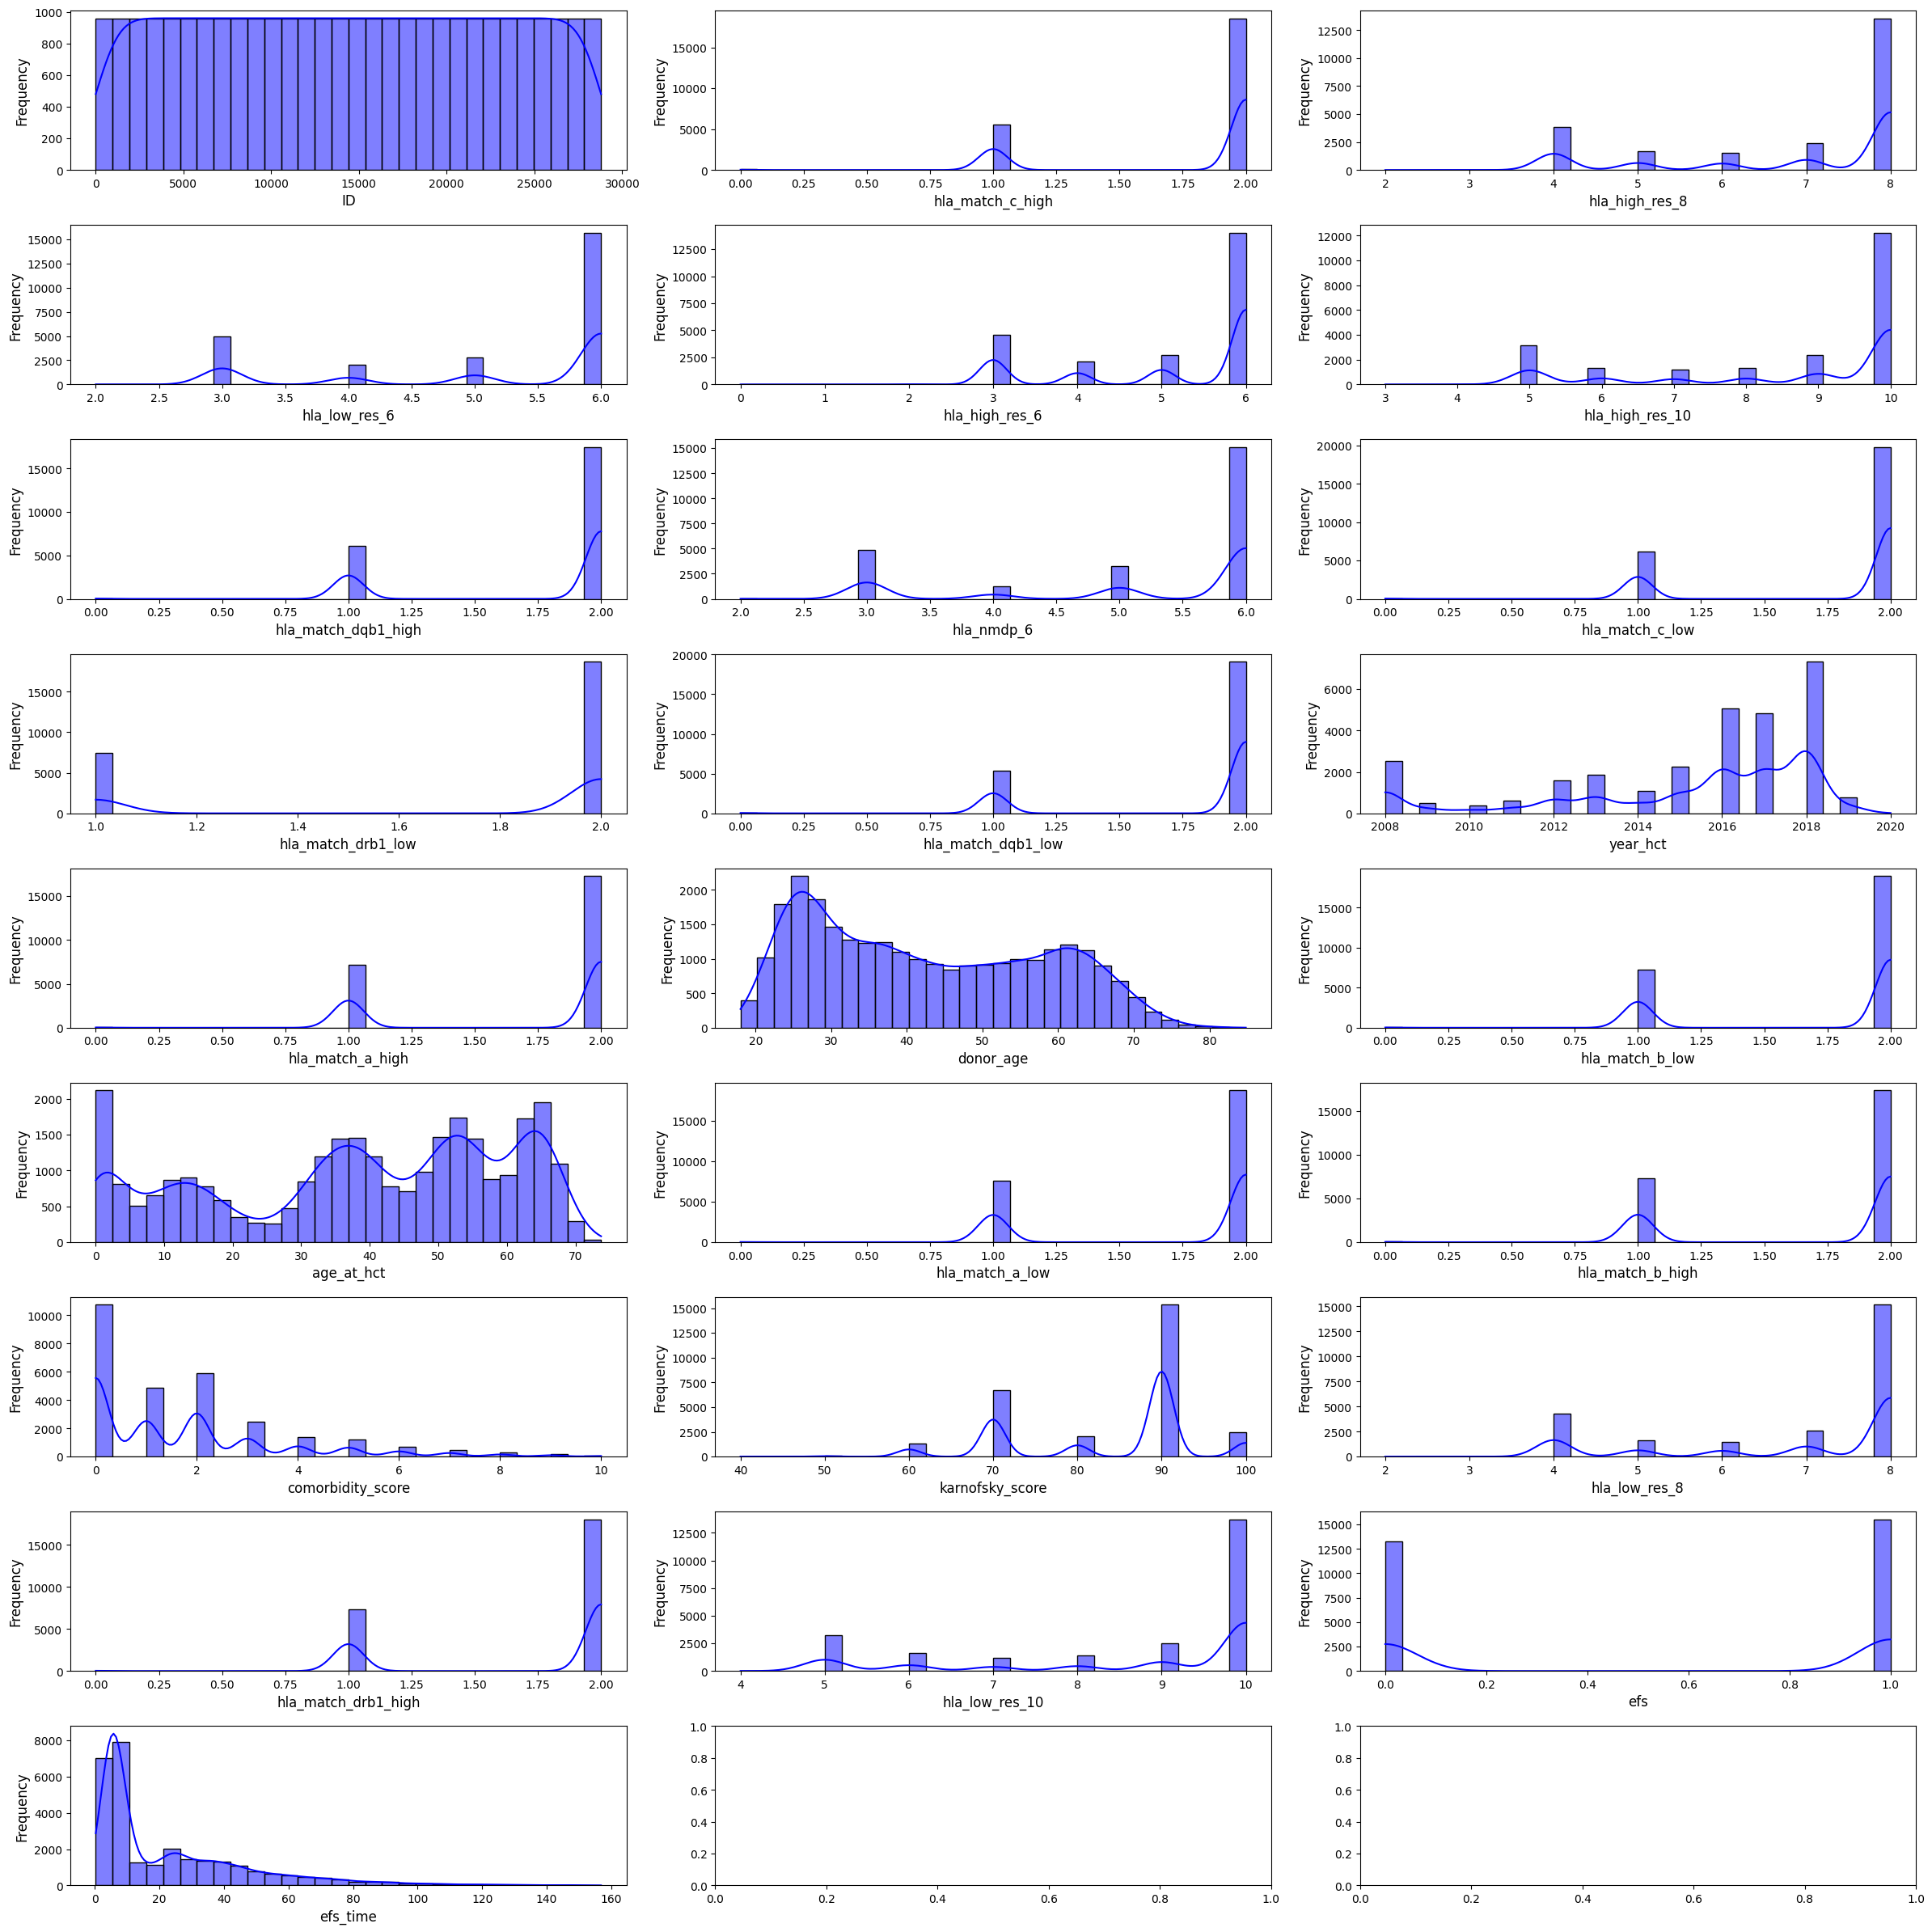

In [ ]:
# use histogram to understand the distribution of the data.
num_cols = len(df.select_dtypes(include='number').columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)

fig, axes = plt.subplots(num_rows, 3, figsize=(24, 24))

for i, col in enumerate(df.select_dtypes(include='number').columns):
    ax = axes[i // 3, i % 3]  # Properly index the subplot grid
    sns.histplot(df[col], kde=True, color='blue', bins=30, ax=ax)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# use boxplot to understand to check for outliers.
#for i in df.select_dtypes(include='number').columns:
#    sns.boxplot(data=df, x=i)
#    plt.show()


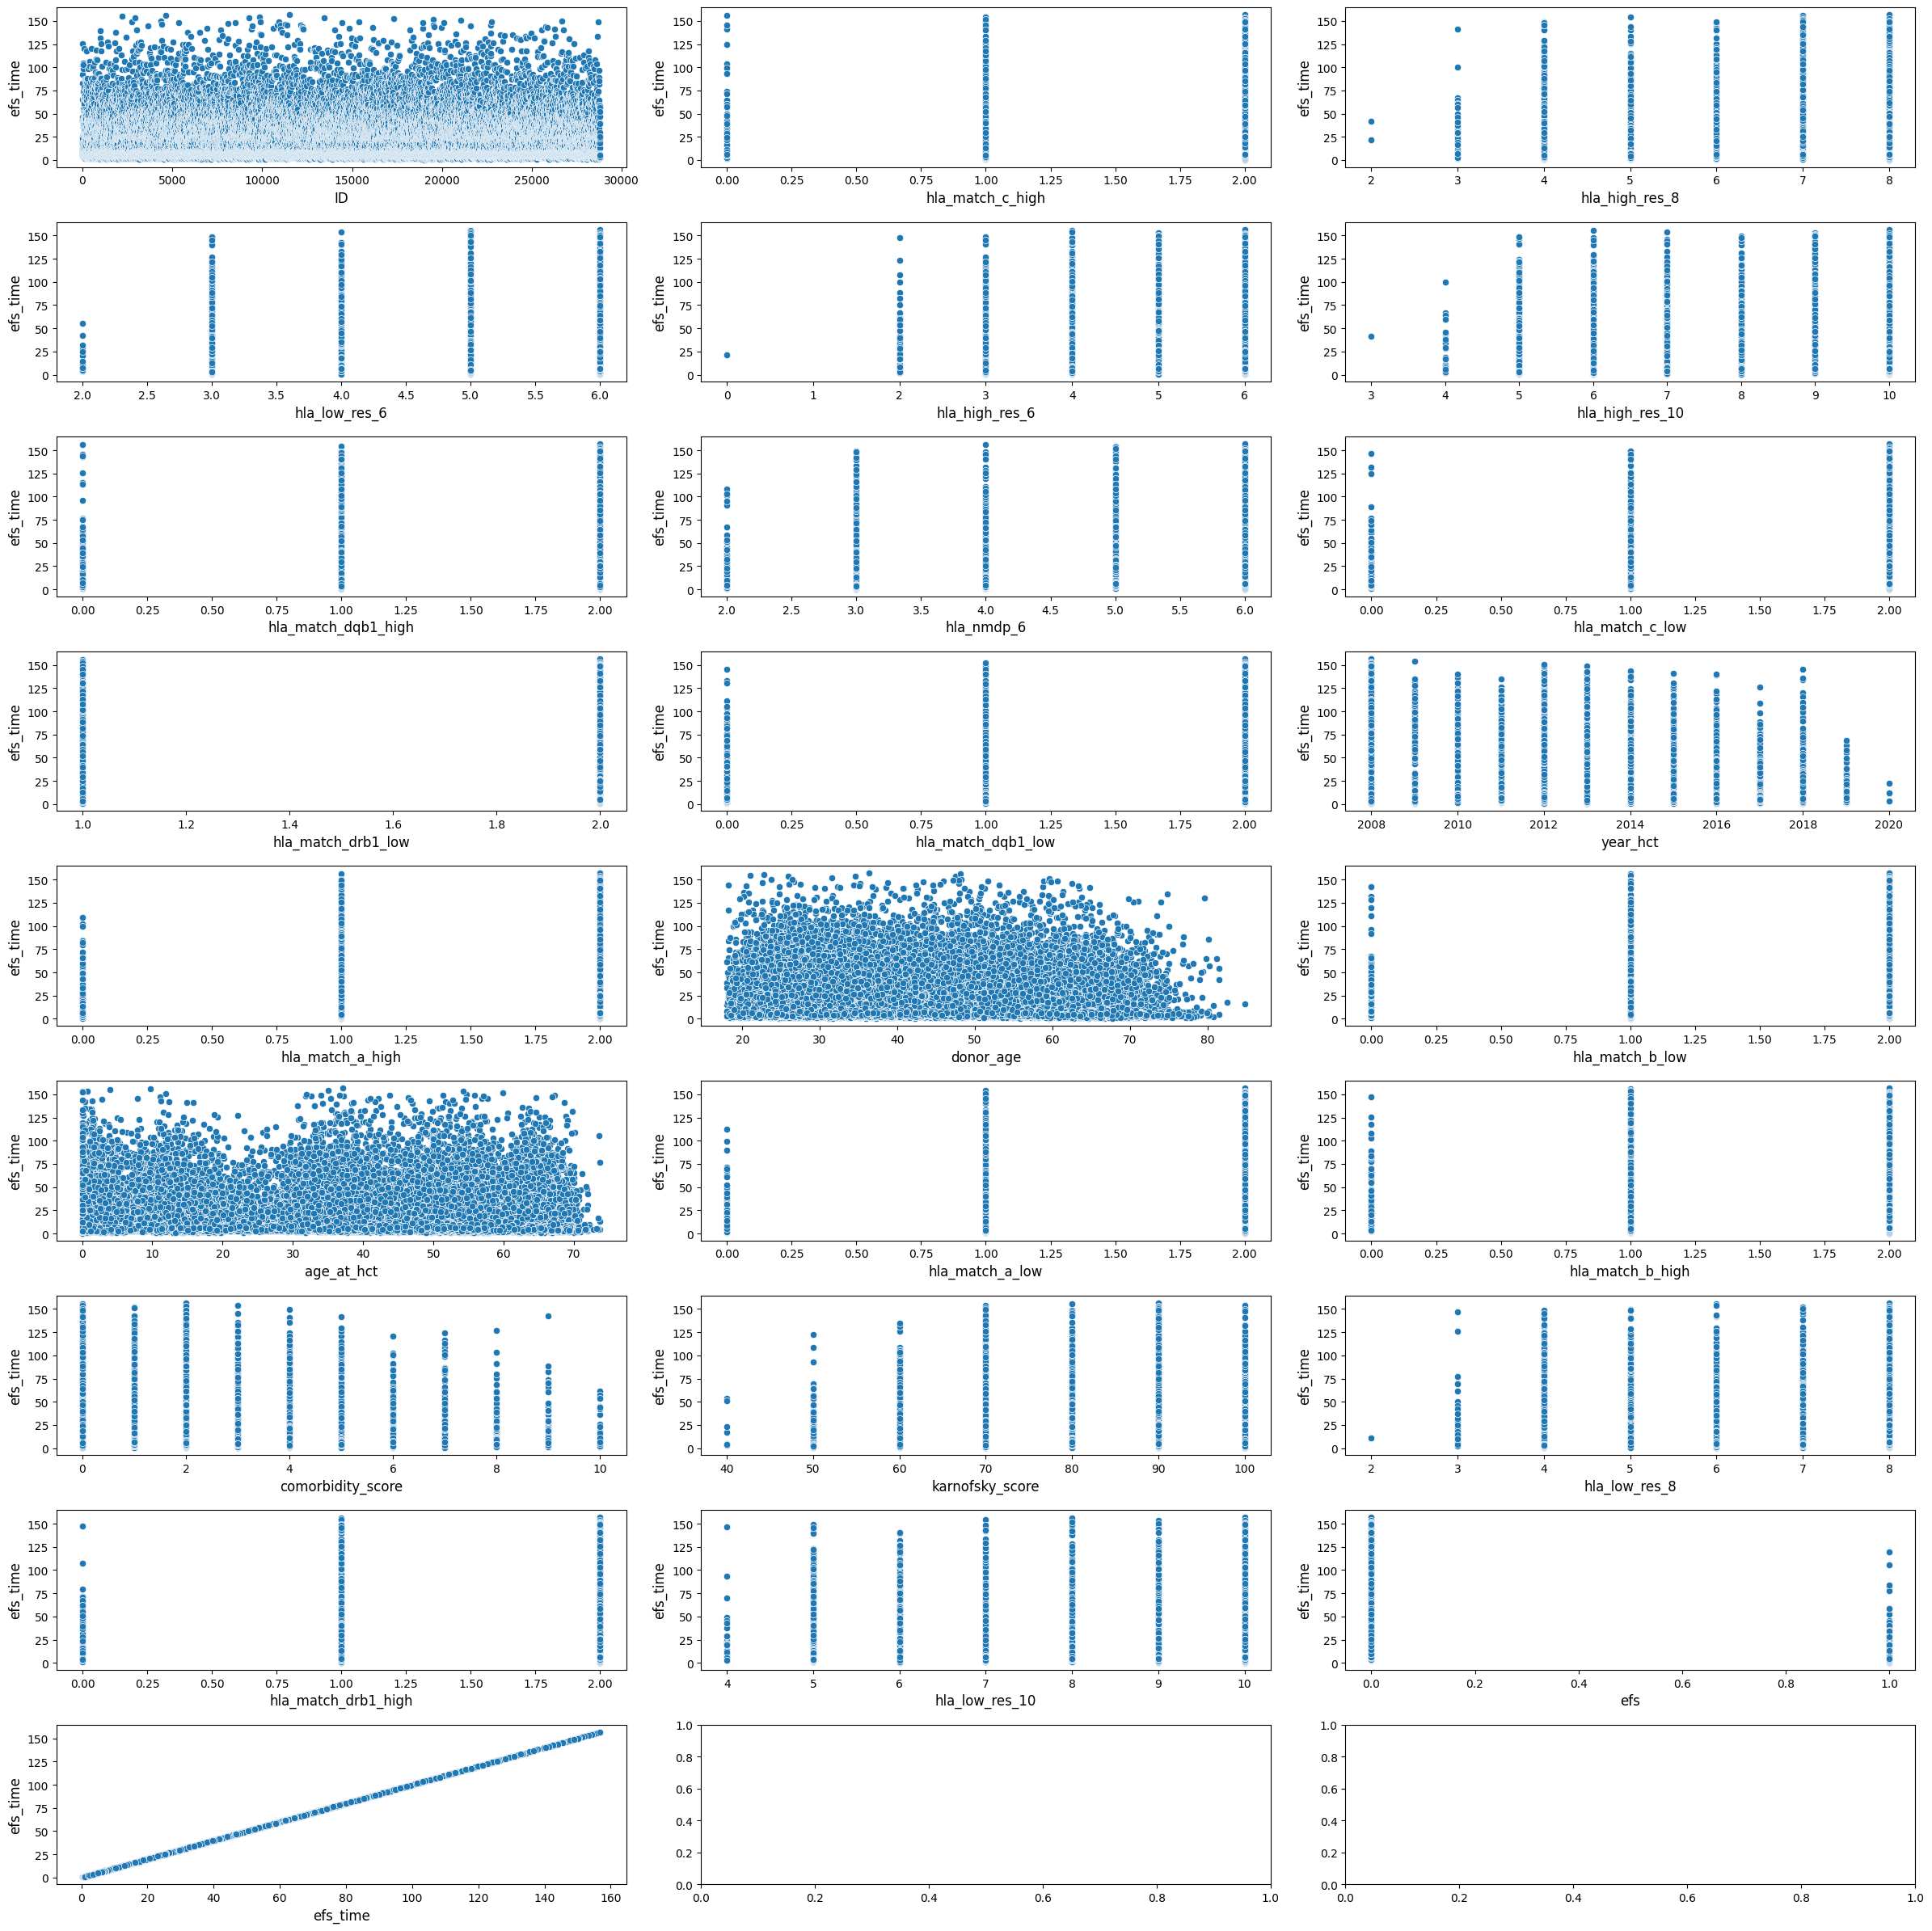

In [ ]:
# scatter the plot to understand the relationship between the features.
fig, axes = plt.subplots(num_rows, 3, figsize=(24, 24))

for i, col in enumerate(df.select_dtypes(include='number').columns):
    ax = axes[i // 3, i % 3]  # Properly index the subplot grid
    sns.scatterplot(data=df, x=col, y='efs_time', ax=ax)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('efs_time', fontsize=12)

plt.tight_layout()
plt.show()

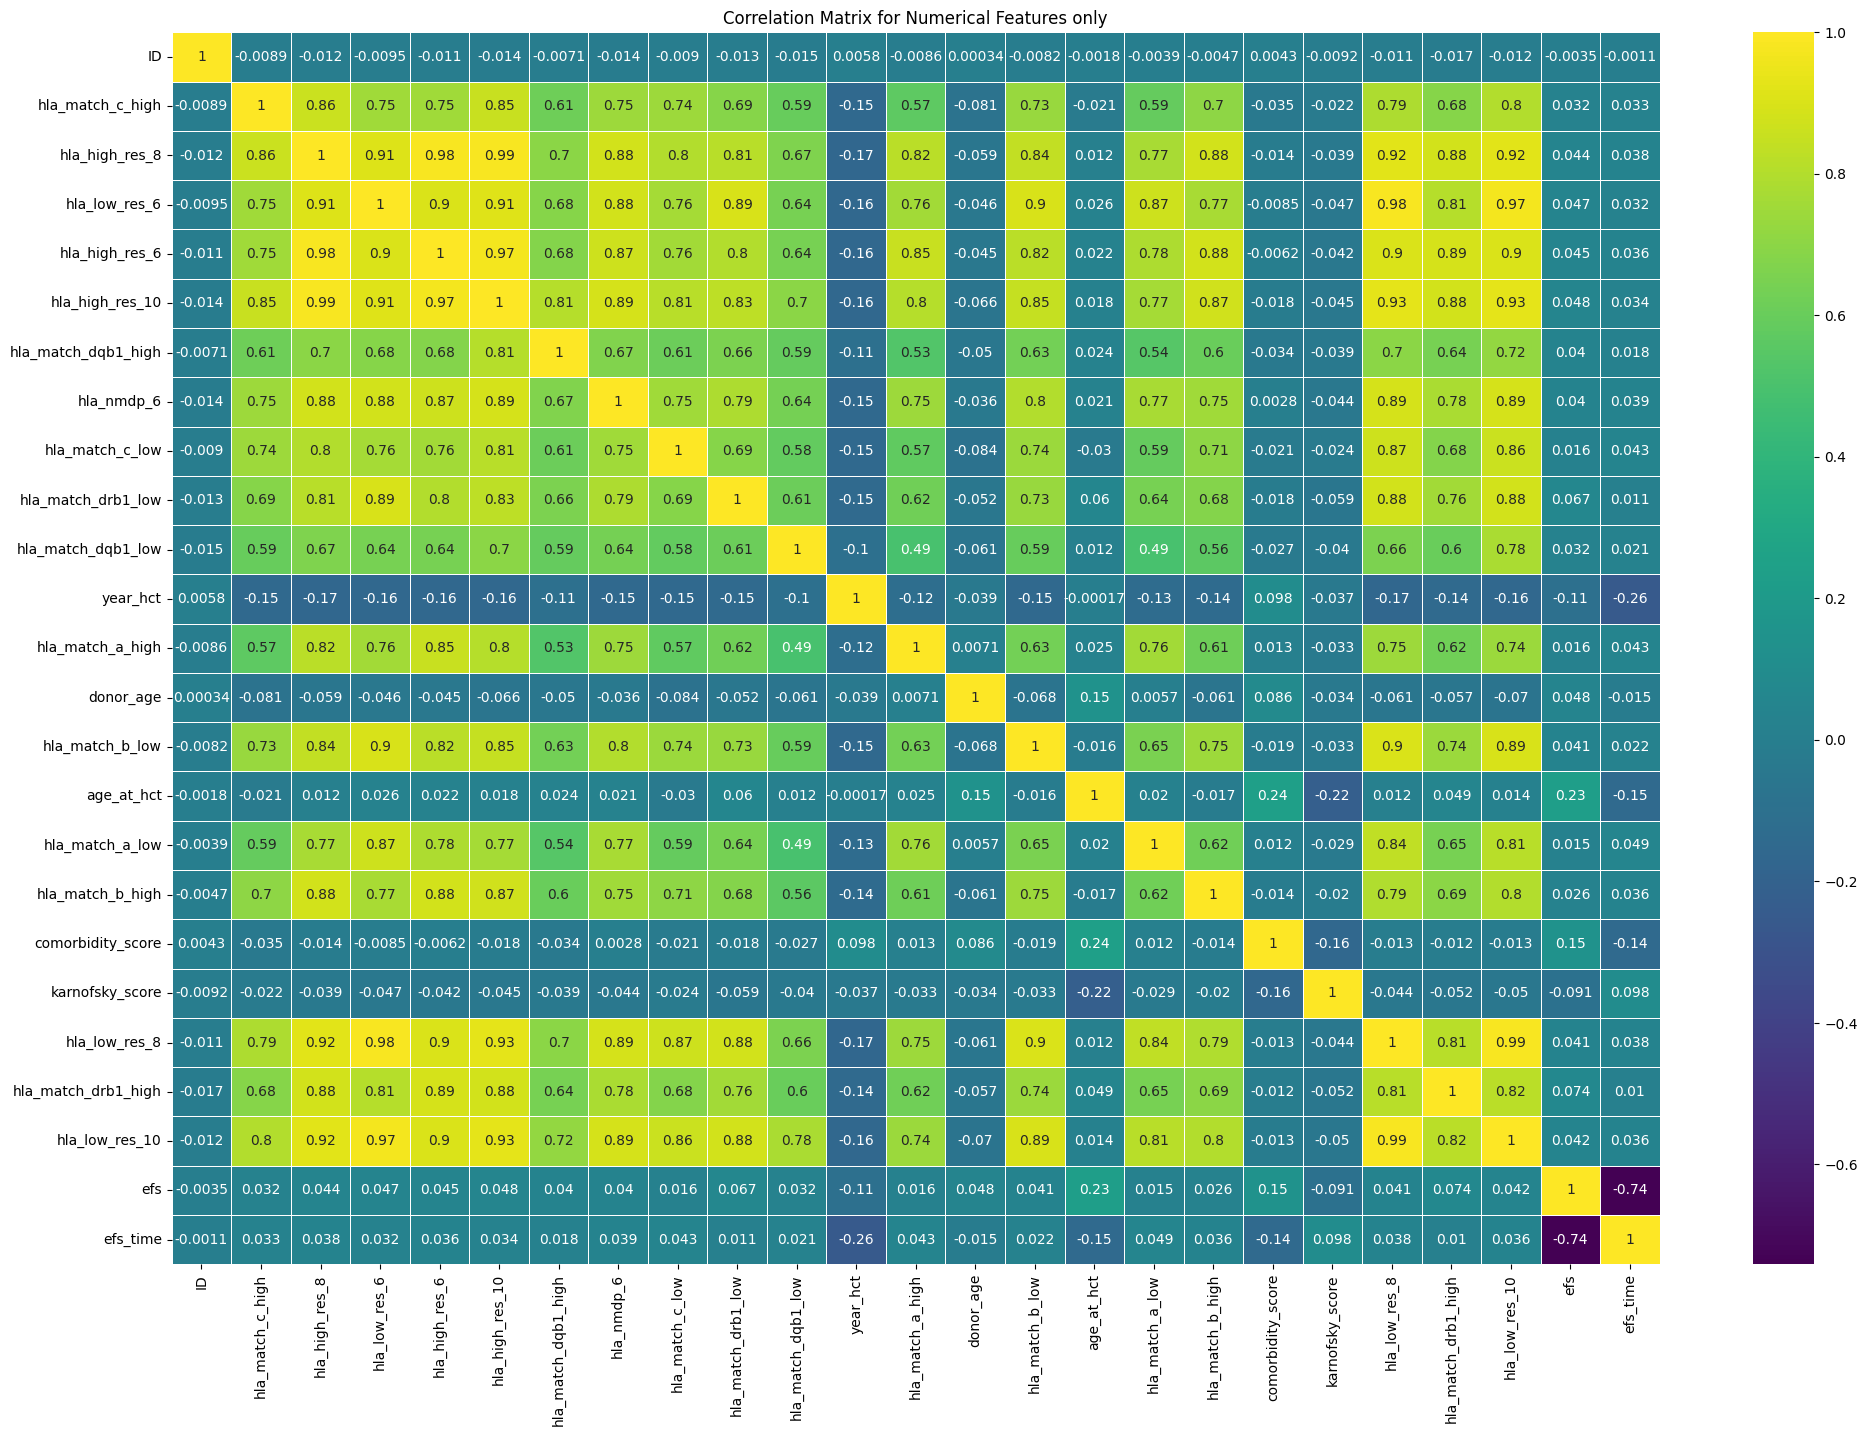

In [ ]:
# Let's compute the correlation matrix for numerical features (excluding categorical and highly missing ones).
numerical_features = df.select_dtypes(include='number')
correlation_matrix = numerical_features.corr()

# Visualizing the correlation matrix.
plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Correlation Matrix for Numerical Features only')
plt.show()

HLA features are moderately correlated, we can assume that the model will predict good results with those features.

In [ ]:
## Missing Values Treatment
df.isnull().sum()

,0
ID,0
dri_score,154
psych_disturb,2062
cyto_score,8068
diabetes,2119
hla_match_c_high,4620
hla_high_res_8,5829
tbi_status,0
arrhythmia,2202
hla_low_res_6,3270


Missing numerical values are discrete. Replacing them with mean, median is not possible. Mode can be a solution here.

In [ ]:
## Missing Values Treatment
numerical_features = df.select_dtypes(include=[np.number])
numerical_features.isnull().sum()

,0
ID,0
hla_match_c_high,4620
hla_high_res_8,5829
hla_low_res_6,3270
hla_high_res_6,5284
hla_high_res_10,7163
hla_match_dqb1_high,5199
hla_nmdp_6,4197
hla_match_c_low,2800
hla_match_drb1_low,2643


In [ ]:
# Create the Kernel (MICE model)
kernel = mf.ImputationKernel(
    numerical_features,
    num_datasets=10,
    random_state=42
)

# Perform imputation
kernel.mice(5) # 5 iterations of imputation

imputed_df = kernel.complete_data()

imputed_df.head()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,...,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time
0,0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,9.942,2.0,2.0,0.0,90.0,8.0,2.0,10.0,0.0,42.356
1,1,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,43.705,2.0,2.0,3.0,90.0,8.0,2.0,10.0,1.0,4.672
2,2,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,33.997,2.0,2.0,0.0,90.0,8.0,2.0,10.0,0.0,19.793
3,3,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,43.245,2.0,2.0,0.0,90.0,8.0,2.0,10.0,0.0,102.349
4,4,2.0,8.0,6.0,6.0,10.0,2.0,5.0,2.0,2.0,...,29.740,2.0,2.0,1.0,90.0,8.0,2.0,10.0,0.0,16.223


In [ ]:
df[numerical_features.columns] = imputed_df[numerical_features.columns]
df.isnull().sum() / df.shape[0] * 100

,0
ID,0.000000
dri_score,0.534722
psych_disturb,7.159722
cyto_score,28.013889
diabetes,7.357639
hla_match_c_high,0.000000
hla_high_res_8,0.000000
tbi_status,0.000000
arrhythmia,7.645833
hla_low_res_6,0.000000


In [ ]:
# Remove columns with missing values over 50% and remove rows with missing values less than 5%
df.dropna(axis=1, thresh=0.4*df.shape[0], inplace=True)

for col in df.columns:
    if df[col].isna().mean() < 0.05:
        df = df.dropna(subset=[col])

In [ ]:
df.isnull().sum() / df.shape[0] * 100
df.shape

(21214, 58)

In [ ]:
# Fill the missing values with mode.
df.fillna(df.mode().iloc[0], inplace=True)
df.shape

(21214, 58)

In [ ]:
# Download the csv.
#df.to_csv('cleaned_data.csv', index=False)